In [5]:
import re
import pandas as pd
pd.set_option('max_colwidth', None)

In [57]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isaacduong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isaacduong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
BMBF = pd.read_csv('../data/BMBF.csv',encoding='latin1',sep=';')

In [3]:
def cleaned_data(BMBF):
    
    # remove invalid token in columns name
    columns = [c.replace('\"','').replace('=','') for c in BMBF.columns]
    BMBF.columns = columns
    BMBF.drop('Unnamed: 26',axis = 1, inplace = True)
    # remove invalid token in columns values
    for col in columns[:-1]:
        BMBF[col] = BMBF[col].apply(lambda v: v.replace('\"','').replace('=',''))
    
    BMBF['FKZ'] = BMBF['FKZ'].apply(lambda s : s.replace(' ',''))
    
    return BMBF

In [4]:
BMBF = cleaned_data(BMBF)
BMBF

,FKZ,Ressort,Referat,PT,Arb.-Einh.,Zuwendungsempfänger,Gemeindekennziffer,Stadt/Gemeinde,Ort,Bundesland,...,Staat.1,Thema,Leistungsplansystematik,Klartext Leistungsplansystematik,Laufzeit von,Laufzeit bis,Fördersumme in EUR,Förderprofil,Verbundprojekt,Förderart
0,03F0212C/7,BMBF,724,PT-J,MGS1,Universität Rostock,13003000,Rostock,Rostock,Mecklenburg-Vorpommern,...,Deutschland,Verbundprojekt MESSIN: Entwicklung und Systemi...,FB4010,Technik-/Infrastrukturentwicklung und -bereits...,01.01.1998,31.08.2000,"648.462,00",Forschung und Entwicklung zur Daseinsvorsorge,MESSIN,PDIR
1,D251800/0,BMBF,314,BIBB,A3.3,"Ministerium für Wirtschaft, Arbeit und Wohnung...",08111000,Stuttgart,Stuttgart,Baden-Württemberg,...,Deutschland,Prozeßorientierte Entwicklungsplanung und Qual...,OB1050,Versuchs- und Modelleinrichtungen und -program...,01.07.1997,30.06.2000,"96.634,00",Forschung und Entwicklung zur Daseinsvorsorge,,PDIR
2,D251800B/2,BMBF,314,BIBB,A3.3,"Ministerium für Wirtschaft, Arbeit und Wohnung...",08111000,Stuttgart,Stuttgart,Baden-Württemberg,...,Deutschland,Wiss. Begl. zum MV 'Prozeßorientierte Entwickl...,OB1050,Versuchs- und Modelleinrichtungen und -program...,01.07.1997,30.06.2000,"157.457,00",Forschung und Entwicklung zur Daseinsvorsorge,,PDIR
3,50WM9821/6,BMWi,IVD5,DLR-RFM,AR-AF,Fraunhofer-Gesellschaft zur Förderung der ange...,09162000,München,München,Bayern,...,Deutschland,Untersuchung des Schäumens von Metallen unter ...,IB3010,Forschung unter Weltraumbedingungen - Material...,01.03.1998,31.12.2001,"452.356,00",Technologie- und Innovationsförderung,,PDIR
4,50WB9716/8,BMWi,IVD5,DLR-RFM,AR-AF,Universität Hohenheim,08111000,Stuttgart,Stuttgart,Baden-Württemberg,...,Deutschland,Der Einfluß verschiedener Gravitationsbedingun...,IB3020,Forschung unter Weltraumbedingungen - Biowisse...,01.01.1998,31.03.2002,"358.551,00",Technologie- und Innovationsförderung,,PDIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272239,03EN4022J,BMWi,IIC6,PT-J,ESN4,Georgsmarienhütte GmbH,03459019,Georgsmarienhütte,Georgsmarienhütte,Niedersachsen,...,Deutschland,Verbundvorhaben: SiPro - Simulationsbasiertes ...,EA3251,Energiesparende Industrieverfahren - Fertigung...,01.01.2022,31.12.2024,"227.401,00",Technologie- und Innovationsförderung,SiPro,PDIR
272240,67K18622,BMU,IKIII3,PT-ZUG,NKI,Amt Bokhorst-Wankendorf,01057085,Wankendorf,Wankendorf,Schleswig-Holstein,...,Deutschland,KSI: Sanierung der Innenbeleuchtung im Dorfgem...,FA1913,KSI - Klimaschutztechnologien bei der Stromnut...,01.03.2022,28.02.2023,"10.802,00",Forschung und Entwicklung zur Daseinsvorsorge,,PDIR
272241,13N15865,BMBF,514,PT-VDI,TZ-PT,kiutra GmbH,09162000,München,München,Bayern,...,Deutschland,Verbundprojekt: Materials in Quantum Computing...,L01010,Quantentechnologien: Quantencomputing und -sim...,01.09.2021,31.05.2024,"228.580,00",Technologie- und Innovationsförderung,Materials in Quantum Computing,PDIR
272242,13N15863,BMBF,514,PT-VDI,TZ-PT,Keysight Technologies Deutschland GmbH,08115003,Böblingen,Böblingen,Baden-Württemberg,...,Deutschland,Verbundprojekt: Materials in Quantum Computing...,L01010,Quantentechnologien: Quantencomputing und -sim...,01.09.2021,31.05.2024,"99.593,00",Technologie- und Innovationsförderung,Materials in Quantum Computing,PDIR


In [56]:
BMBF['Ressort'].value_counts()

BMBF        174414
BMWi         45421
BMU          26089
BMVI         18718
BMEL          7510
BMJV_BLE        92
Name: Ressort, dtype: int64

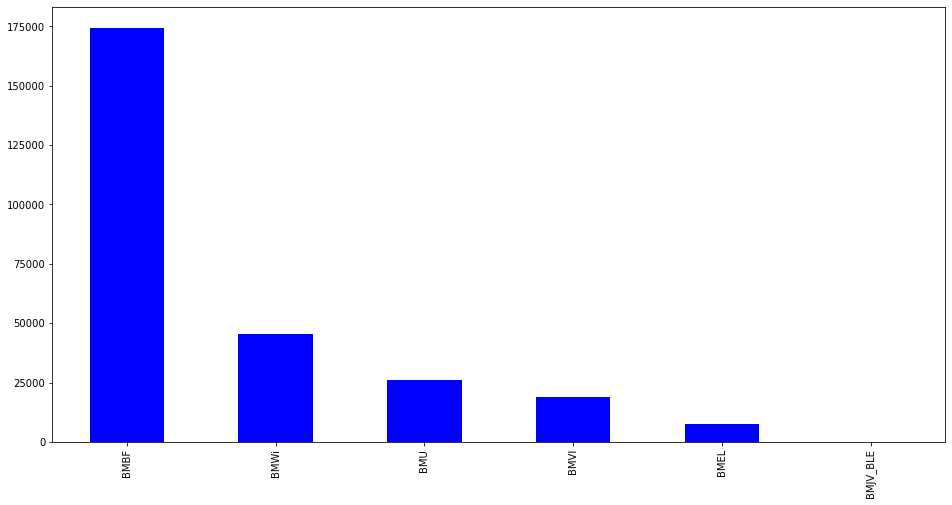

In [35]:

BMBF['Ressort'].value_counts().plot(kind='bar',color='blue',figsize=(16,8));

In [53]:
# almost no duplicates, FKZ is unique and seems to appropriate for identifying the grants
BMBF['FKZ'].duplicated().sum()

4

In [ ]:
#check which character are used for FKZ
FKZ_char = set([l for sublist in BMBF['FKZ'].tolist() for l in sublist])
# {'+','-','.','_','0-9','A-Z','Ä','Ö','Ü'}
 

In [51]:
def extract_FKZ(FKZ):
    ''' . and _ appear in only few FKZs and will be left out to avoid false negative results'''
    
    pattern = '[ÄÜÖA-Z0-9/+-]{3,10}'
    match=re.search(pattern,FKZ)
    if match:
        return match.group()
    
extract_FKZ('Grant/No.03G0833B') 

'03G0/833B'